In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from imblearn.over_sampling import SMOTE
import torch.nn.functional as F
import numpy as np
import time
import seaborn as sns
import copy
import pandas as pd

### Load the dataset

In [ ]:
df = pd.read_csv("star_classification.csv")
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


### Visualizing the Class Distribution

Here, a pie plot is created using Seaborn's pie plt to visualize the distribution of the classes within the dataset.  The alpha parameter sets the transparency of the bars, enhancing the visualization if there's any overlap between them. This plot helps in understanding the balance or imbalance among the classes in the dataset.

class GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64


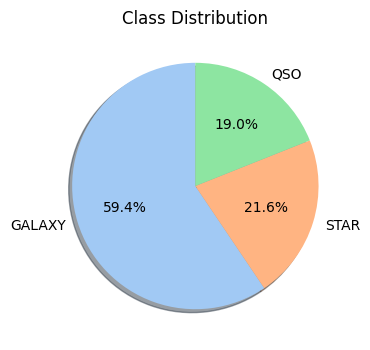

In [ ]:
# Calculate the counts of each class
class_counts = df['class'].value_counts()
print('class',class_counts)

# Create a pie chart
plt.figure(figsize=(6, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'), shadow=True)
plt.title('Class Distribution')
plt.show()

### Data Preprocessing and Device Configuration
We perform two primary tasks:

Label Encoding: The "class" column in the DataFrame df is transformed using LabelEncoder. This converts the class labels into integers, making them suitable for machine learning algorithms.

 Device Configuration: The code sets up the device for the PyTorch model by checking whether a GPU (with CUDA) is available. If CUDA is available, it will use the GPU; otherwise, it defaults to the CPU. The variable device is then assigned to the chosen computation device (either "cuda" or "cpu").

In [ ]:
LE = LabelEncoder()
df["class"] = LE.fit_transform(df["class"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Data Visualization Functions
We define two functions, plot and log_plot, for visualizing the distributions of specified columns in the dataset. These functions are useful for comparing the distributions across different classes and for the entire dataset.

plot(columns): This function creates a grid of KDE (Kernel Density Estimation) plots for the given columns, separating the distributions based on the "class" feature. It organizes the plots into a grid with 3 columns, calculating the required number of rows to accommodate all the given columns.

log_plot(columns): Similar to the plot function, this one visualizes the distributions of the logarithms of the given columns. This can be helpful in understanding the logarithmic characteristics of the data.

In [ ]:
def plot(columns):
    # Determine the number of rows and columns for the grid
    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))

    # Create a figure and an array of subplots with 3 columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten the axes array if there is only one row
    if n_rows == 1:
        axes = axes.flatten()

    # Loop through the columns and plot each one in a subplot
    for idx, column in enumerate(columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        for i in range(3):
            sns.kdeplot(
                data=df[df["class"] == i][column],
                label=LE.inverse_transform([i]),
                ax=ax,
            )

        sns.kdeplot(data=df[column], label=["All"], ax=ax)
        ax.legend()

    # If there are any unused subplots, remove them
    for idx in range(len(columns), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

    plt.show()



In [ ]:
def log_plot(columns):
    # Determine the number of rows and columns for the grid
    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))

    # Create a figure and an array of subplots with 3 columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

    # Flatten the axes array if there is only one row
    if n_rows == 1:
        axes = axes.flatten()

    # Loop through the columns and plot each one in a subplot
    for idx, column in enumerate(columns):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]

        for i in range(3):
            sns.kdeplot(
                data=np.log(df[df["class"] == i][column]),
                label=LE.inverse_transform([i]),
                ax=ax,
            )

        sns.kdeplot(data=np.log(df[column]), label=["All"], ax=ax)
        ax.legend()

    # If there are any unused subplots, remove them
    for idx in range(len(columns), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

    plt.show()

### Initial Exploration of the Data
We display the head of the DataFrame, giving the first few rows. Additionally, we retrieve the list of all column names within the DataFrame. We do this to understand the structure of the dataset, the features available, and to prepare the dataset for further data analysis or preprocessing.

In [ ]:
df.head()
columns = df.columns.tolist()
columns

['obj_ID',
 'alpha',
 'delta',
 'u',
 'g',
 'r',
 'i',
 'z',
 'run_ID',
 'rerun_ID',
 'cam_col',
 'field_ID',
 'spec_obj_ID',
 'class',
 'redshift',
 'plate',
 'MJD',
 'fiber_ID']

### Plotting KDE graph for all features for selection
By plotting KDE graphs for the SDSS Dataset we understand which features are useful to distinguish between classes

<ipython-input-6-f9d2d30b398b>:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-6-f9d2d30b398b>:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-6-f9d2d30b398b>:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-6-f9d2d30b398b>:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df[column], label=["All"], ax=ax)
<ipython-input-6-f9d2d30b398b>:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(
<ipython-input-6-f9d2d30b398b>:20: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to dis

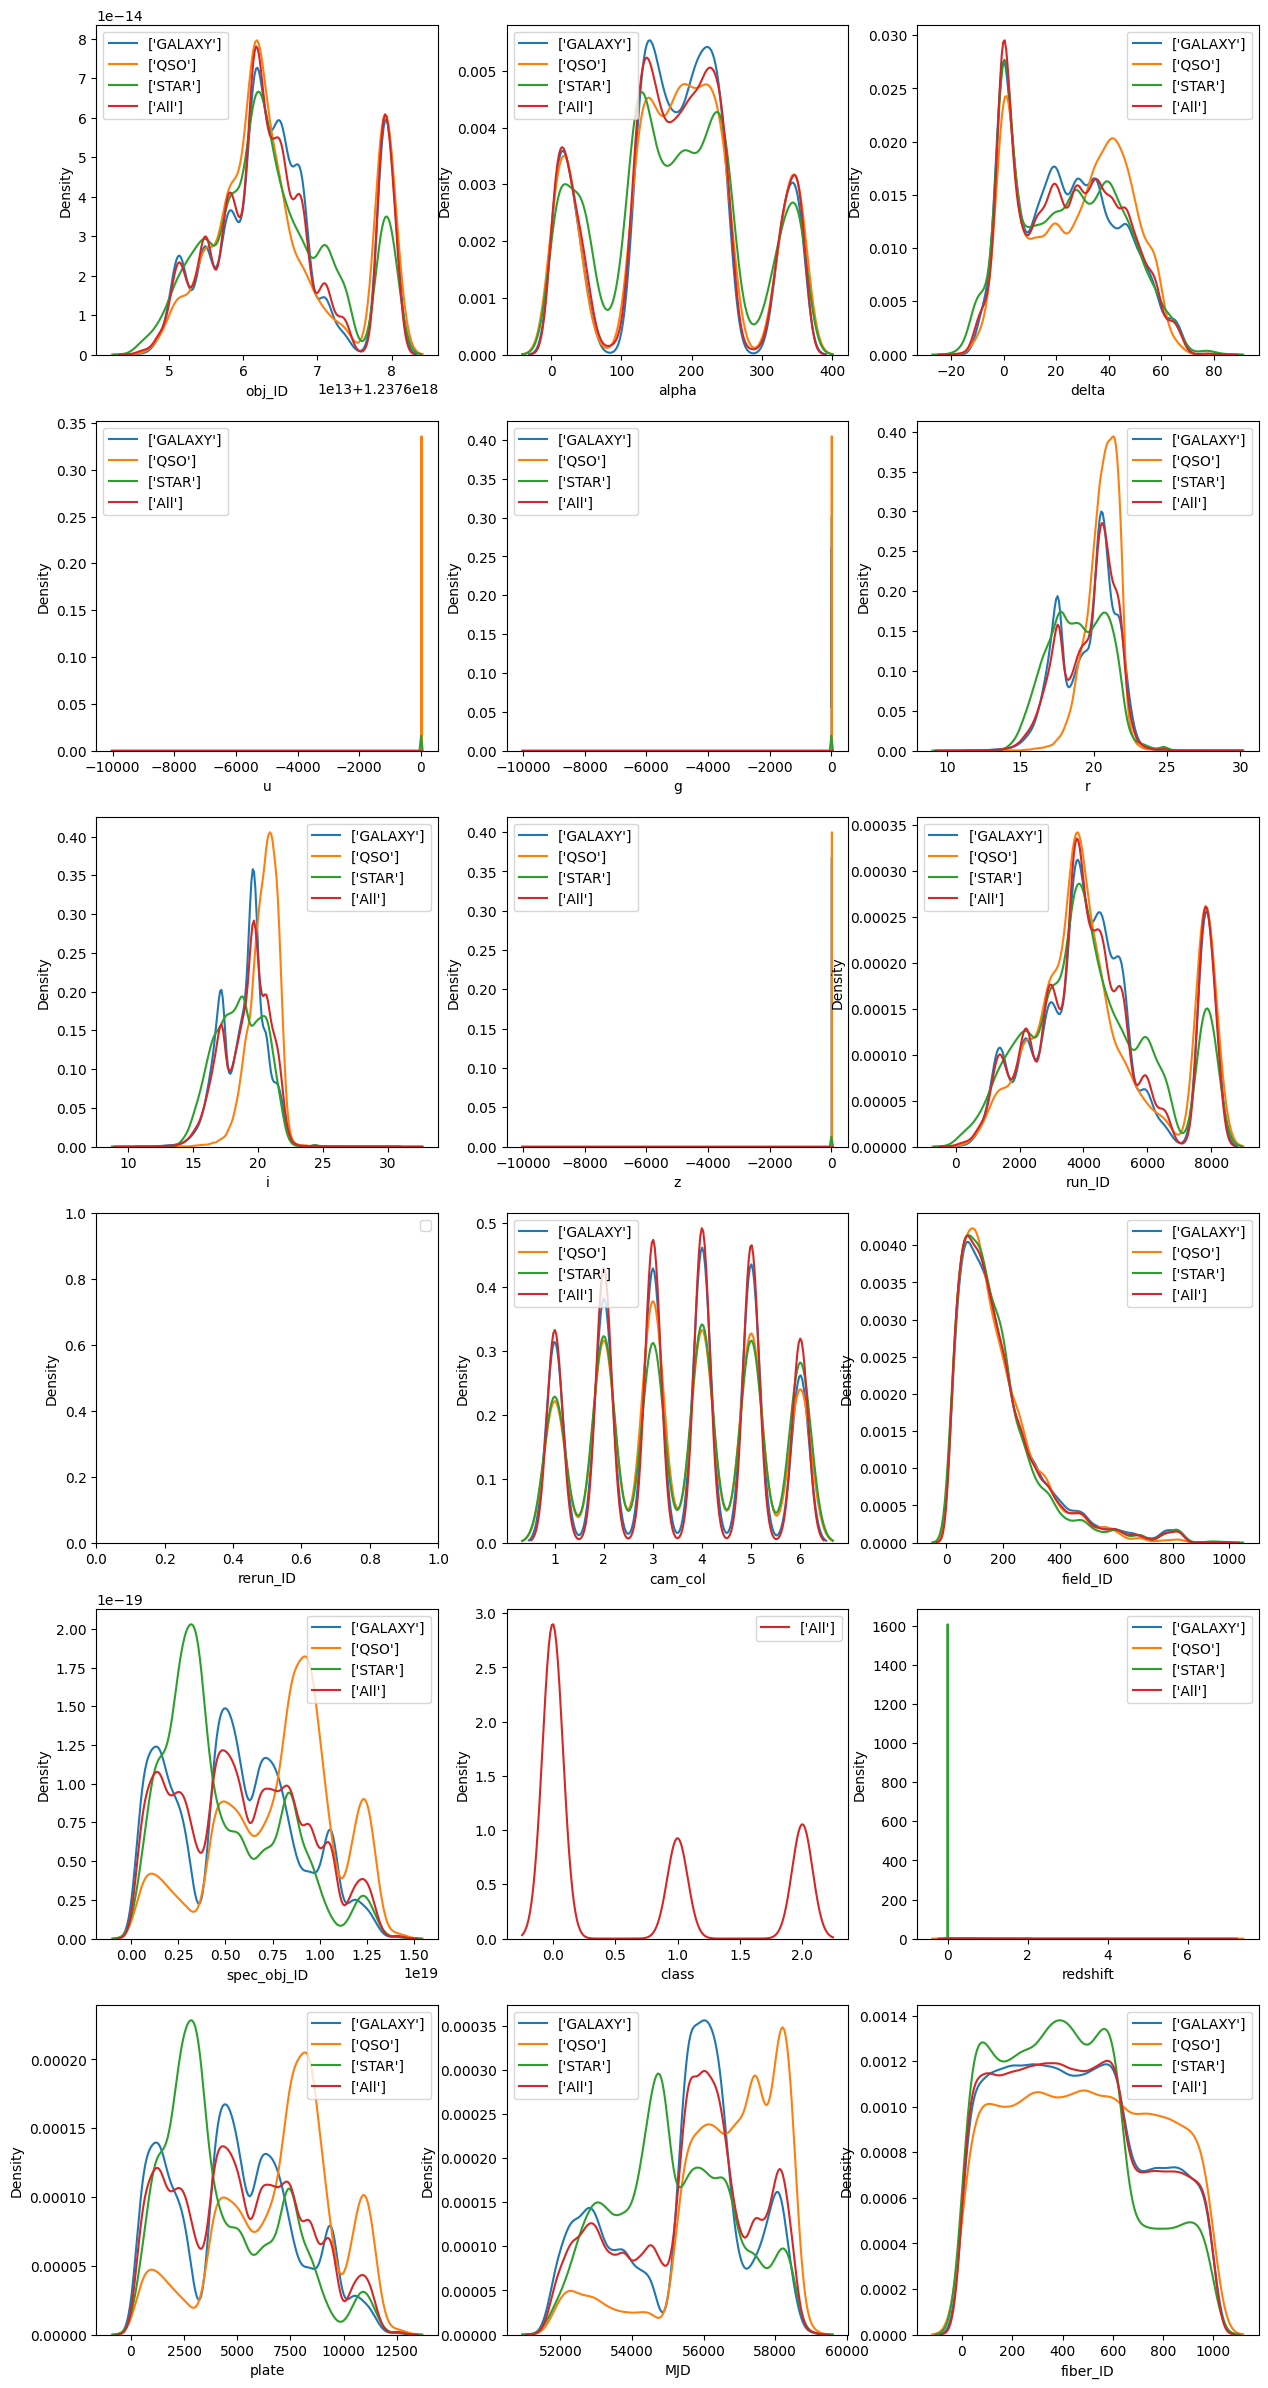

In [ ]:
plot(columns)

### Visualizing logarthmic data
Plotting KDE plot on logarithmic data for features spanning several orders of magnitude for better feature selection

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(uf

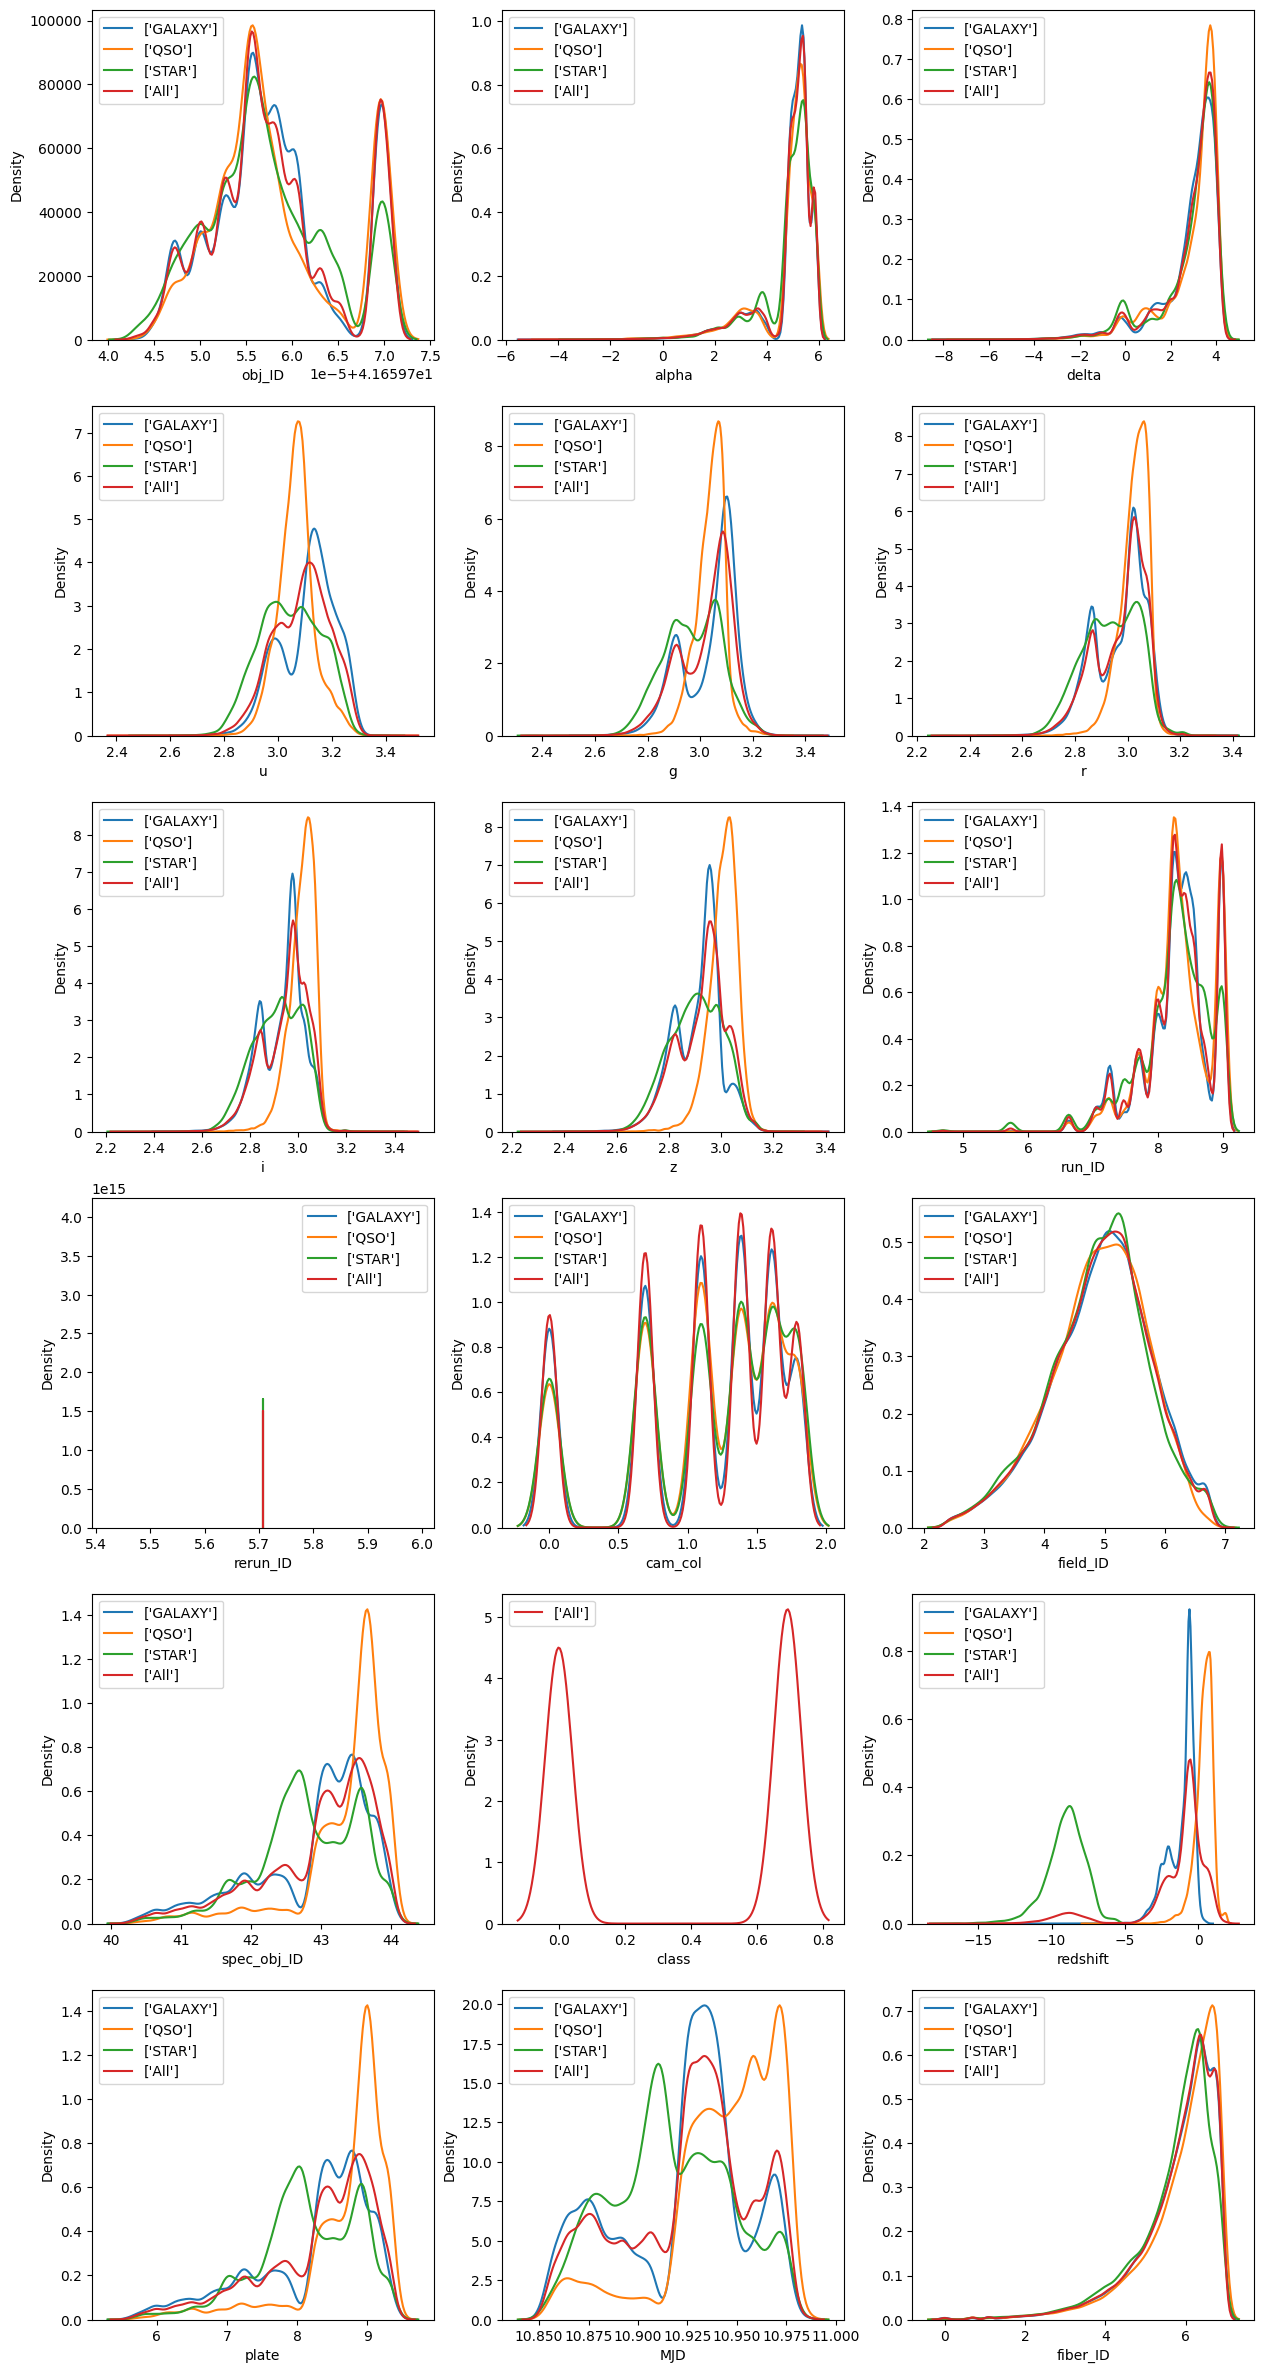

In [ ]:
log_plot(columns)

### Preparing Features and Labels
From the original DataFrame df, specific columns which don't offer any significant difference in distribution such as "obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "fiber_ID", and "class" are dropped to form the feature set X. The "class" column is isolated to form the label set Y. This step ensures that only relevant information is retained for the model's training, validation, and testing.

In [ ]:
columns_to_drop = [
    "obj_ID",
    "run_ID",
    "rerun_ID",
    "cam_col",
    "field_ID",
    "fiber_ID",
    "class",
]
X = df.drop(columns=columns_to_drop)
Y = df["class"]

### Splitting the Dataset into Training, Validation, and Test Sets
The dataset is divided into three subsets: training, validation, and test sets. Initially, the data is split into training (80%) and test (20%) sets using a random seed of 42. The training set is further split into training (90%) and validation (10%) sets with a random seed of 24. This division ensures that the model can be trained on one subset, tuned with the validation set, and finally evaluated on the test set, providing a robust assessment of the model's performance.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=24
)

### Handling Class Imbalance with SMOTE
We utilize the Synthetic Minority Over-sampling Technique (SMOTE) to address class imbalance in the training data. By setting a random state and specifying the number of nearest neighbors (k_neighbors), the method synthesizes new examples in the minority class, balancing the class distribution. This resampled training data, X_train_res and Y_train_res, can help in training a model that is more sensitive to the minority class, potentially improving performance on imbalanced data.

In [ ]:
sm = SMOTE(random_state=30, k_neighbors=5)
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)

### Data Preprocessing and Transformation
We apply feature scaling to the training, validation, and test datasets using the StandardScaler from scikit-learn. By transforming the datasets with the same scaler, it ensures that the mean is 0 and the variance is 1 across all feature dimensions, aiding in training the neural network. The scaled data is then converted to PyTorch tensors, enabling GPU acceleration and compatibility with PyTorch functions. The target labels are also converted to PyTorch tensors, preserving their original datatype as long integer.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train_res.values, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val.values, dtype=torch.long)
Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

### Creating Dataloaders
We construct PyTorch DataLoader objects for the training, validation, and test datasets, wrapped in the TensorDataset class. It sets the batch size to 100 and enables shuffling for the training data. The dataloaders dictionary provides an easy way to access the loaders for different phases. We also calculate and print the sizes of each dataset, which is essential for later computations and monitoring the progress of training.

In [ ]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
batch_size = 100
dataloaders = {
    "train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
    "val": DataLoader(val_dataset, batch_size=batch_size),
    "test": DataLoader(test_dataset, batch_size=batch_size),
}

dataset_sizes = {
    "train": len(train_dataset),
    "val": len(val_dataset),
    "test": len(test_dataset),
}
print(f"dataset_sizes = {dataset_sizes}")

dataset_sizes = {'train': 128490, 'val': 8000, 'test': 20000}


### Preprocessing Data Batches
Here we loop through the different phases ("train", "val", "test") and iterates over the data batches. It reshapes the inputs of every batch, flattening them to the correct size. This is essential to ensure that the data is in the proper format before feeding it into the neural network.

In [ ]:
phases = ["train", "val", "test"]
for phase in phases:
    for inputs, labels in dataloaders[phase]:
        # This flattens every batch to the correct size!
        inputs = inputs.view(inputs.shape[0], -1)

### Defining Model Hyperparameters
Here, the model's hyperparameters are defined, specifying the input size, hidden layers' sizes, number of classes, learning rate, number of epochs, and dropout rate. These values will be used to configure the neural network during instantiation and training.

In [ ]:
input_size = len(inputs[0])
hidden_size1 = 256
hidden_size2 = 256
hidden_size3 = 128
num_classes = 3
learning_rate = 0.002
num_epochs = 200
dropout = 0.67

### StellarClassifier Class Definition
The StellarClassifier class defines a custom neural network model designed for classifying stellar objects. The architecture consists of the following:

Three Hidden Layers: With customizable sizes hidden_size1, hidden_size2, and hidden_size3.
Leaky ReLU Activation Functions: Applied after each hidden layer.
Batch Normalization: Used to normalize the activations of the neurons in the hidden layers.
Dropout: A regularizing technique where random neurons are turned off during training, controlled by the dropout parameter.
Output Layer: A linear layer that reduces to num_classes dimensions, representing the classification logits.
The model is constructed using PyTorch's sequential container, and the forward method takes an input tensor x and returns the processed output through the network layers. This class encapsulates a complete feed-forward neural network for classification, providing a simple interface to train and evaluate the model.

In [ ]:
class StellarClassifier(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size1,
        hidden_size2,
        hidden_size3,
        num_classes,
        dropout,
    ):
        super(StellarClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(hidden_size1),
            self.dropout,
            nn.Linear(hidden_size1, hidden_size2),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(hidden_size2),
            self.dropout,
            nn.Linear(hidden_size2, hidden_size3),
            nn.LeakyReLU(0.02),
            nn.BatchNorm1d(hidden_size3),
            self.dropout,
            nn.Linear(hidden_size3, num_classes),
        )

    def forward(self, x):
        return self.layers(x)

### Instantiation of StellarClassifier¶
The code creates an instance of the StellarClassifier class using specified parameters for input size, hidden layers, number of classes, and dropout rate. The model is then moved to the specified device (e.g., CPU or GPU) and its structure is printed, providing a visual overview of its architecture.

In [ ]:
stellar_model = StellarClassifier(
    input_size,
    hidden_size1,
    hidden_size2,
    hidden_size3,
    num_classes,
    dropout,
).to(device)
print(stellar_model)

StellarClassifier(
  (dropout): Dropout(p=0.67, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=11, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.67, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.67, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): LeakyReLU(negative_slope=0.02)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.67, inplace=False)
    (12): Linear(in_features=128, out_features=3, bias=True)
  )
)


### Initializing training model method
We define the train_model function to train, validate, and test the StellarClassifier model:

Initialization: Sets up variables for tracking the best model weights and training curves.
Training Loop: Iterates through epochs, performing training, validation, and testing.
Loss and Accuracy Tracking: Monitors loss and accuracy for all phases.
Best Model Selection: Stores the best model weights based on validation accuracy.
Returns: The best model weights and the training curves. This function takes in the model, data loaders, dataset sizes, loss function, optimizer, scheduler, and number of epochs as parameters, encapsulating the entire training process.

In [ ]:
def train_model(
    model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25
):
    since = time.time()

    best_model_wts = copy.deepcopy(
        model.state_dict()
    )  # keep the best weights stored separately
    best_acc = 0.0
    best_epoch = 0

    # Each epoch has a training, validation, and test phase
    phases = ["train", "val", "test"]

    # Keep track of how loss and accuracy evolves during training
    training_curves = {}
    for phase in phases:
        training_curves[phase + "_loss"] = []
        training_curves[phase + "_acc"] = []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 10)

        for phase in phases:
            if phase == "train":
                model.train()  # Set model to training mode

            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # This ensures all of our datapoints are flattened
                # before feeding them to our model
                inputs = inputs.view(inputs.shape[0], -1)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, predictions = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + update weights only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            # Converting to scalars to plot graphs
            if torch.is_tensor(epoch_loss):
                epoch_loss = epoch_loss.detach().cpu().item()
            if torch.is_tensor(epoch_acc):
                epoch_acc = epoch_acc.detach().cpu().item()
            training_curves[phase + "_loss"].append(epoch_loss)
            training_curves[phase + "_acc"].append(epoch_acc)

            print(f"{phase:5} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            # deep copy the model if it's the best accuracy (based on validation)
            if phase == "val" and epoch_acc > best_acc:
                best_epoch = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:4f} at epoch {best_epoch}")

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, training_curves

### Model Training Configuration and Execution
Here we perform the following tasks:

Assign Model: Initializes the model with the predefined stellar_model.
Loss Function: Defines the criterion using Cross-Entropy Loss.
Optimizer: Sets up the Adam optimizer with the learning rate and weight decay to prevent overfitting
Scheduler: Implements an exponential learning rate scheduler with a specific decay rate.
Training Execution: Calls the train_model function with the model, dataloaders, dataset sizes, criterion, optimizer, scheduler, and number of epochs to commence training.
The final trained model and training curves are stored for further analysis and visualization.

In [ ]:
model = stellar_model

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=4e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
model, training_curves = train_model(
    model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs
)


Epoch 1/200
----------
train Loss: 0.3116 Acc: 0.8964
val   Loss: 0.2623 Acc: 0.9044
test  Loss: 0.2669 Acc: 0.9071

Epoch 2/200
----------
train Loss: 0.2784 Acc: 0.9222
val   Loss: 0.1930 Acc: 0.9537
test  Loss: 0.2058 Acc: 0.9468

Epoch 3/200
----------
train Loss: 0.2663 Acc: 0.9260
val   Loss: 0.2176 Acc: 0.9405
test  Loss: 0.2300 Acc: 0.9358

Epoch 4/200
----------
train Loss: 0.2677 Acc: 0.9266
val   Loss: 0.2331 Acc: 0.9429
test  Loss: 0.2472 Acc: 0.9378

Epoch 5/200
----------
train Loss: 0.2675 Acc: 0.9255
val   Loss: 0.3054 Acc: 0.9051
test  Loss: 0.3210 Acc: 0.8996

Epoch 6/200
----------
train Loss: 0.2576 Acc: 0.9305
val   Loss: 0.2080 Acc: 0.9379
test  Loss: 0.2134 Acc: 0.9367

Epoch 7/200
----------
train Loss: 0.2534 Acc: 0.9319
val   Loss: 0.2360 Acc: 0.9366
test  Loss: 0.2490 Acc: 0.9303

Epoch 8/200
----------
train Loss: 0.2517 Acc: 0.9329
val   Loss: 0.2321 Acc: 0.9334
test  Loss: 0.2473 Acc: 0.9283

Epoch 9/200
----------
train Loss: 0.2469 Acc: 0.9346
val   Los

### Visualization and Utility Functions
Here, we import essential libraries for plotting and metrics and define several utility functions to help with the evaluation and visualization of the training process.

plot_training_curves: Visualizes the loss and accuracy over epochs for different phases like training, validation, and testing.
classify_predictions: Returns predictions, labels, and scores for the given data.
plot_cm: Plots a confusion matrix that displays the counts for true and predicted class labels.
plot_lr_scheduler: Plots the learning rate across epochs, showcasing how it changes throughout training.
These functions assist in understanding how the model performs during and after training, enabling easy analysis of accuracy, loss, learning rate, and classification results.

In [ ]:
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize


# Utility functions for plotting
def plot_training_curves(
    training_curves, phases=["train", "val", "test"], metrics=["loss", "acc"]
):
    epochs = list(range(len(training_curves["train_loss"])))
    for metric in metrics:
        plt.figure()
        plt.title(f"Training curves - {metric}")
        for phase in phases:
            key = phase + "_" + metric
            if key in training_curves:
                metric_plot = training_curves[phase + "_" + metric]
                plt.plot(epochs, metric_plot)
        plt.xlabel("epoch")
        plt.legend(labels=phases)


def classify_predictions(model, device, dataloader):
    model.eval()  # Set model to evaluate mode
    all_labels = torch.tensor([]).to(device)
    all_scores = torch.tensor([]).to(device)
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in dataloader:
        # Important! We need to flatten every datapoint
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = torch.softmax(model(inputs), dim=1)
        _, preds = torch.max(outputs, 1)
        scores = outputs[:, 1]
        all_labels = torch.cat((all_labels, labels), 0)
        all_scores = torch.cat((all_scores, scores), 0)
        all_preds = torch.cat((all_preds, preds), 0)
    return (
        all_preds.detach().cpu(),
        all_labels.detach().cpu(),
        all_scores.detach().cpu(),
    )


def plot_cm(model, device, dataloaders, phase="test"):
    class_labels = [0, 1, 2]
    preds, labels, scores = classify_predictions(model, device, dataloaders[phase])

    cm = metrics.confusion_matrix(labels, preds)
    disp = metrics.ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=class_labels
    )
    ax = disp.plot().ax_
    ax.set_title("Confusion Matrix -- counts")


def plot_lr_scheduler(optimizer, num_epochs):
    lr = []
    for epoch in range(num_epochs):
        scheduler.step()
        lr.append(optimizer.param_groups[0]["lr"])
    plt.plot(lr)
    plt.xlabel("epoch")
    plt.ylabel("learning rate")
    plt.title("Learning rate over epochs")
    plt.show()

### Plotting Training Curves
This code snippet calls the plot_training_curves function to visualize the training, validation, and test curves for the model. These curves can provide insight into the learning dynamics, such as how well the model is learning, if it's overfitting, or if adjustments to the training process might be needed.

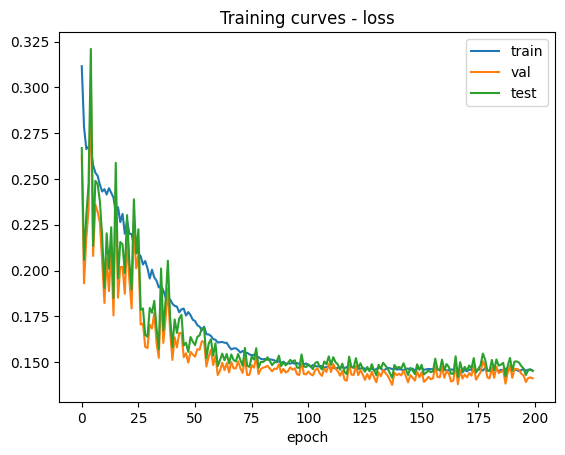

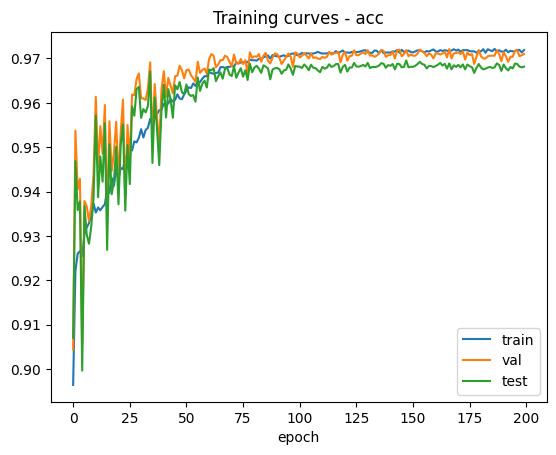

In [ ]:
plot_training_curves(training_curves, phases=["train", "val", "test"])

### Plotting Confusion Matrix for Test Phase
Here we invoke the plot_cm function, which plots the confusion matrix for the test phase of the model's evaluation. The confusion matrix provides a summary of the correct and incorrect classifications made by the model, and is a useful tool for understanding the model's performance on different classes.

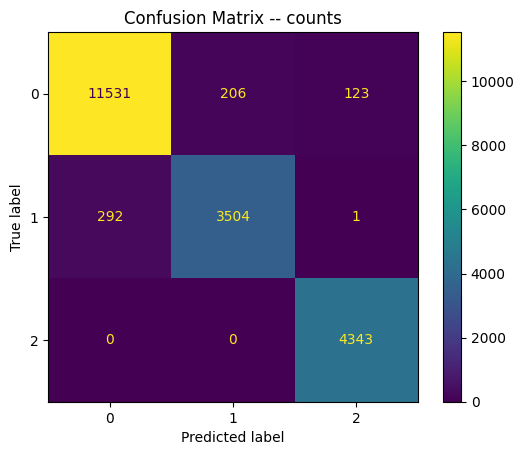

In [ ]:
res = plot_cm(model, device, dataloaders, phase="test")

### Plotting the Learning Rate Scheduler
We call the plot_lr_scheduler function to plot the learning rate across epochs. It visually represents how the learning rate changes throughout the training process, following the schedule set by the learning rate scheduler. This can be helpful in understanding how the learning rate evolves during training and in fine-tuning the training process.

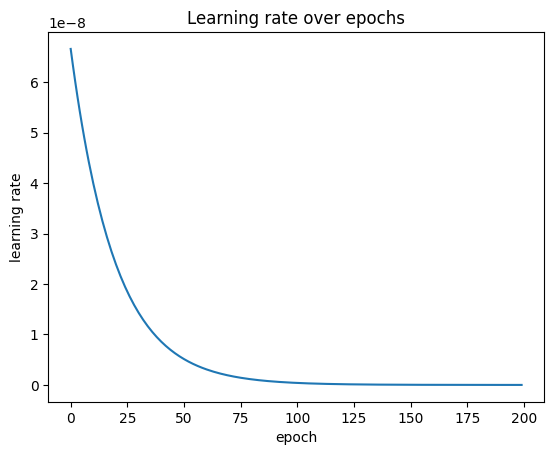

In [ ]:
plot_lr_scheduler(optimizer, num_epochs)

### Conclusion
The deep neural network model implemented in this notebook is designed to classify celestial objects in the SDSS dataset into three distinct categories: stars, galaxies, and quasars. The dataset was carefully preprocessed, including handling imbalanced classes using SMOTE and feature scaling using StandardScaler. The model consists of three hidden layers with Leaky ReLU activations and dropout for regularization.

Key components and specifications include:

Layers: Three hidden layers with 256, 256, and 128 units respectively, followed by Leaky ReLU activations.
Dropout: Implemented to prevent overfitting, with a rate of 67%.
Optimization: Utilized Adam optimizer with learning rate 0.002, and a learning rate scheduler that exponentially decays the learning rate.
Epochs: The model was trained for 200 epochs.
The training process was carried out with a well-defined training, validation, and testing regime, keeping track of both loss and accuracy. The best model weights were saved based on validation accuracy.